# Свёрточные нейронные сети

In [18]:
import os
import struct
import numpy as np
import tensorflow as tf
np.warnings.filterwarnings('ignore')

### Рассчёт выхода свёртки
Размер определяется количеством сдвигов фильтра вдоль входного вектора

$o = \left \lfloor{ \frac{n+2p-m}{s}}\right \rfloor+1$
- n - размер входного вектора
- m - размер фильтра
- p - дополнение
- s - страйд

>**Пример:**
<br>входной вектор размера 10 c ядром свёртки размера 5, дополнением 2 и страйдом 1:
<br>$\left \lfloor{ \frac{10+2*2-5}{1}}\right \rfloor+1$ = 10

## Одномерная свертка

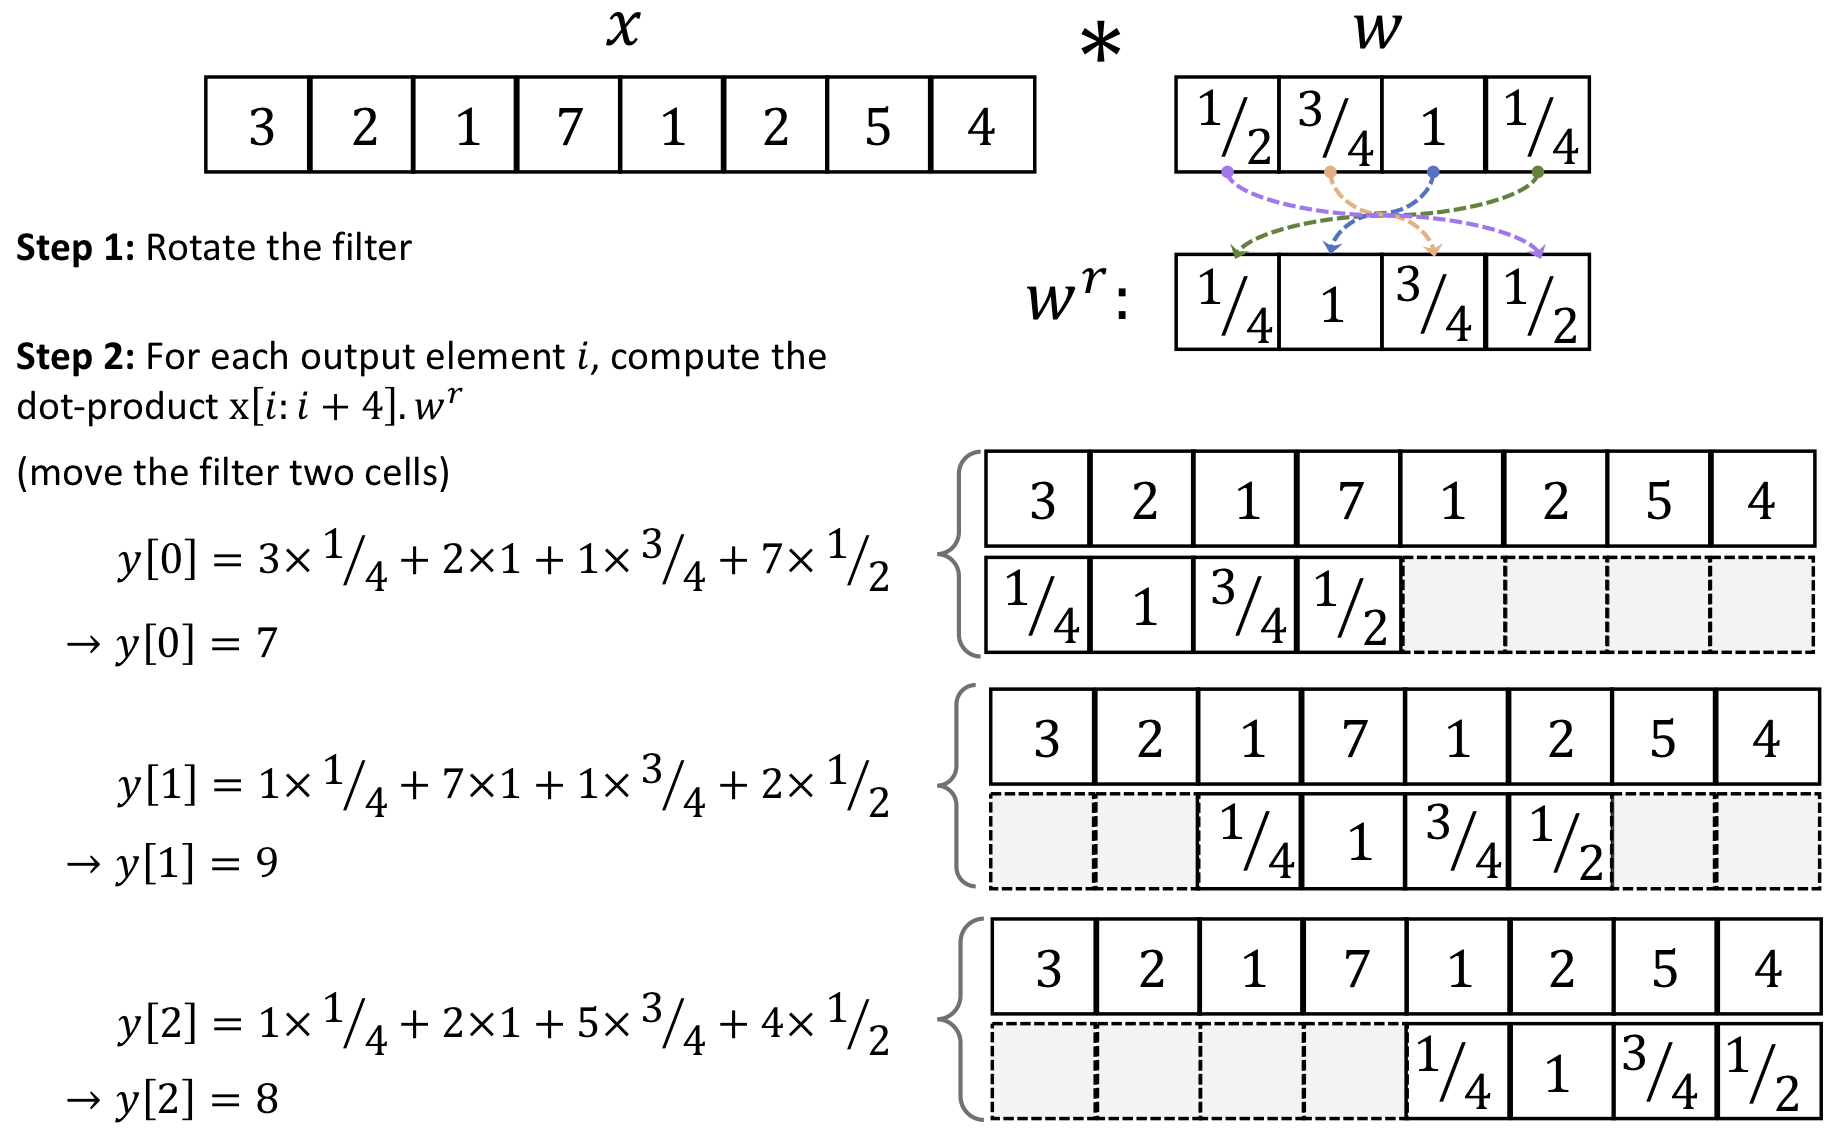

повёрнутый фильтр $w^r$ смещается на две ячейки. Это смещение называется страйдом - $s$.

In [3]:
def conv1d(x, w, p=0, s=1):
    """ Вычисление свёртки в 1 измернии"""
    w_rot    = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot)) / s) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


# Test
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Реализация Conv1d:\t', conv1d(x, w, p=2, s=1))
print('Результат Numpy: \t',  np.convolve(x, w, mode='same')) 

Реализация Conv1d:	 [ 5. 14. 16. 26. 24. 34. 19. 22.]
Результат Numpy: 	 [ 5 14 16 26 24 34 19 22]


## Двумерная свёртка

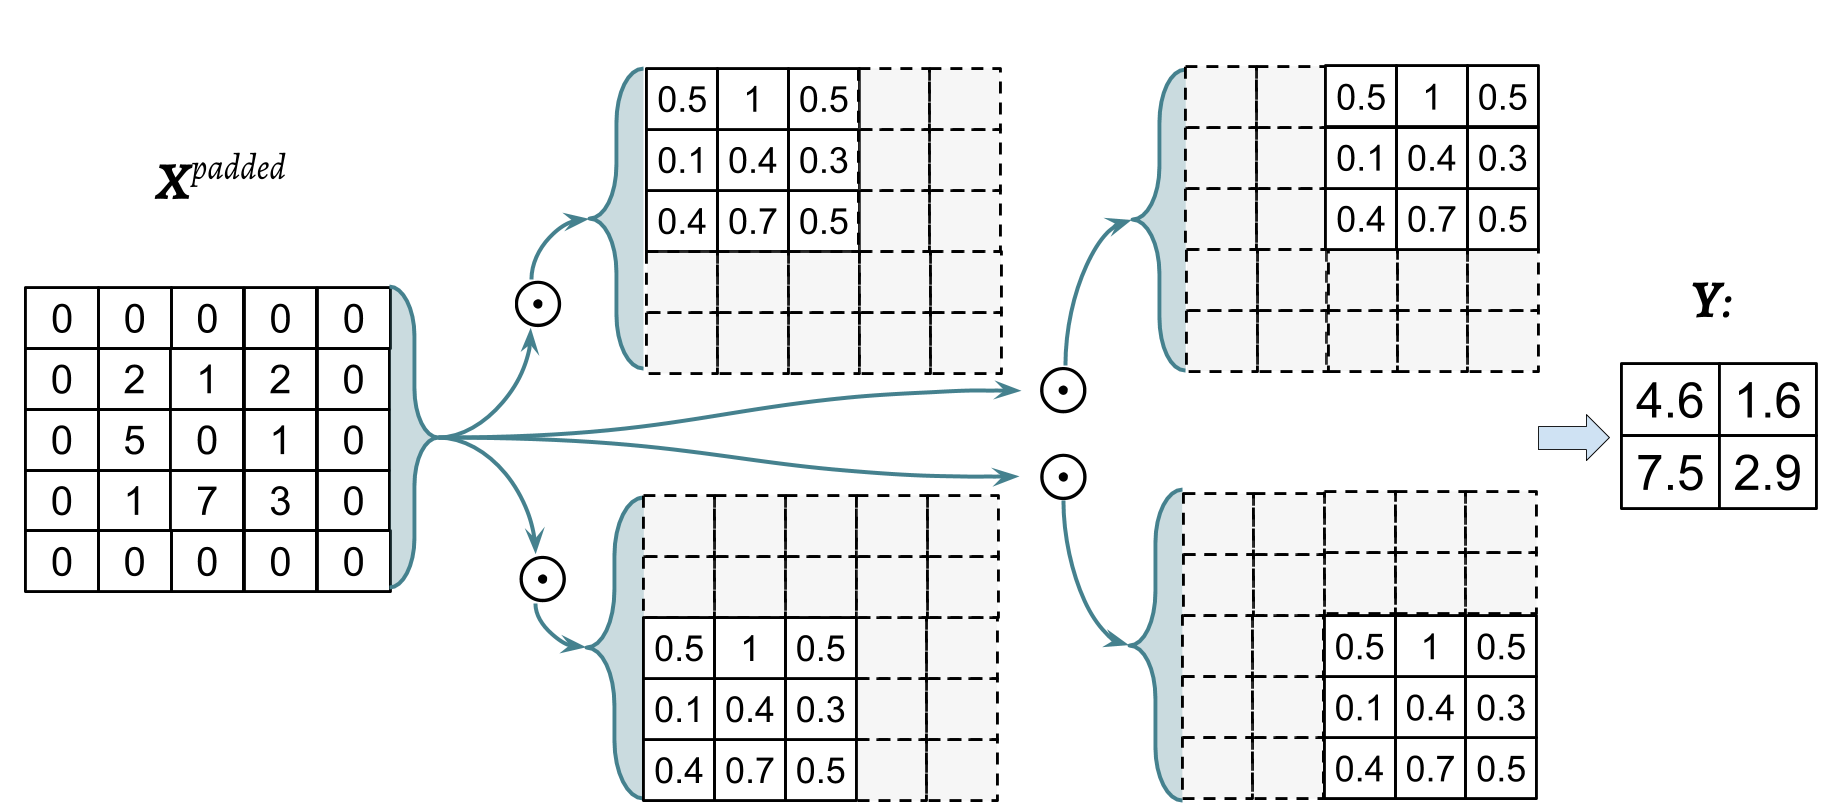

In [4]:
import scipy.signal
def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot  = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
             p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Реализация Conv2d:\n', conv2d(X, W, p=(1, 1), s=(1, 1)))
print('\nРезультат SciPy:\n', scipy.signal.convolve2d(X, W, mode='same'))

Реализация Conv2d:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]

Результат SciPy:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


### Работа с множественными входными или цветовыми каналами

### $ X_{N_1N_2C_{input}}$
$N_1N_2$ - (высота и ширина) - каналы изображения
<br>$C_{input}$ - RGB, количество каналов

Выполняется свёртка для каждого канала отдельно, а потом результаты складываются вместе

Подсчёт обучаемых параметров
<img src='https://user-images.githubusercontent.com/54672403/83789997-35741680-a6a0-11ea-92e5-b9c24a8f9359.png' width='600'>
- три канала |> на каждый по матрице |> с 5 ядрами $m_1$x $m_2$


$m_1$x $m_2*3* 5+5$
<br>+5 - размер вектора смещения $b$





In [5]:
import tensorflow as tf
img_raw = tf.io.read_file('apple.jpg')
img = tf.image.decode_image(img_raw)
print('Размер фото:\t', img.shape)
print('Количество каналов:', img.shape[2])
print('Image data type:', img.dtype)
#~~~~~~~~~~  высота, ширина 
tf.print(img[98:100,98:100, :])

Размер фото:	 (100, 100, 3)
Количество каналов: 3
Image data type: <dtype: 'uint8'>
[[[255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]]]


In [6]:
import imageio
img = imageio.imread('apple.jpg')
print('Размер фото:\t', img.shape)
print('Количество каналов:', img.shape[2])
print('Image data type:', img.dtype)
#~~~~~~   высота, ширина 
print(img[98:100,98:100, :])

Размер фото:	 (100, 100, 3)
Количество каналов: 3
Image data type: uint8
[[[255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]]]


<img src='https://user-images.githubusercontent.com/54672403/83785628-428e0700-a69a-11ea-9e84-2dae6b07c814.png' width='500'>

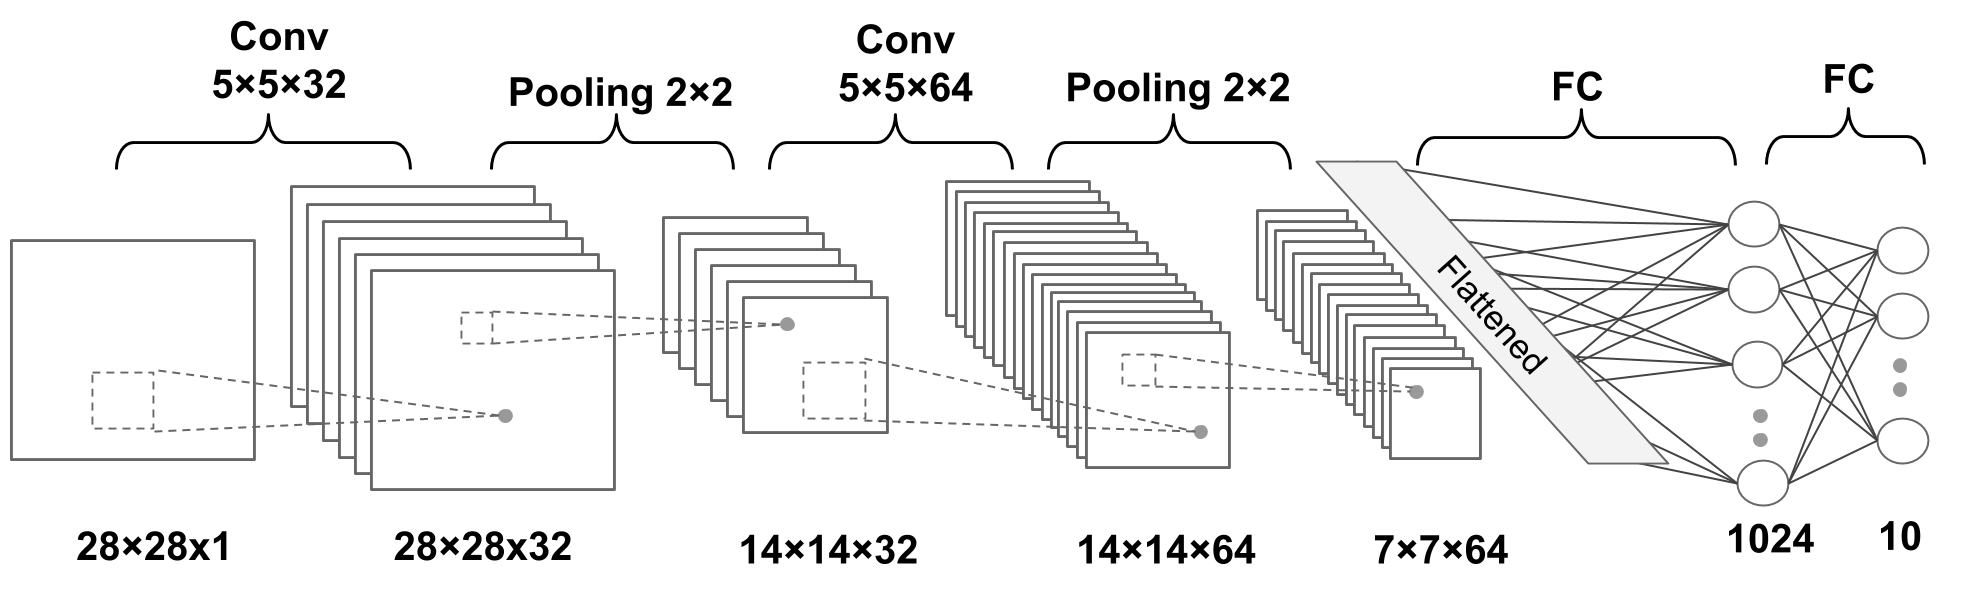

Входные данны проходят черз 2 свёрточных слоя, размером ядра 5х5
<br> 1 свёрточный слой имеет 32 выходны карты признаков
<br> 2 свёрточный слой имеет 64 выходны карты признаков 

За каждым свёрточным слоем идёт слой подвыборки в форме опрации объднения по максимуму
<br>В конце всё выравниватся в массив и передаётся в выходной слой (softmax)

In [7]:
def load_df(path, kind='train'):
    labels_path = os.path.join(path, '%s_labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s_images.idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels
X_train, y_train = load_df('image_data', kind='train')
print('TRAIN df: Rows: %d, columns: %d' % (X_train.shape))

X_test, y_test = load_df('image_data', kind='test')
print(' TEST df: Rows: %d, columns: %d' % (X_test.shape))

TRAIN df: Rows: 60000, columns: 784
 TEST df: Rows: 10000, columns: 784


In [8]:
def batch_generator(X, y, batch_size=64, shuffle=False, random_seed=None):
    idx = np.arange(y.shape[0])
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X, y = X[idx], y[idx]
    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i+batch_size, :], y[i:i+batch_size])

In [9]:
# нормальзация данных
mean_vals = np.mean(X_train, axis=0)
std_val   = np.std(X_train)
X_train_centered = (X_train - mean_vals)/std_val
X_test_centered  = (X_test - mean_vals)/std_val
del X_test, X_train

In [20]:
import tensorflow.compat.v1 as tf
#~~~~~~~~~| Свёрточный слой |~~~~~~~~~#
def conv_layer(input_tensor, name,
               kernel_size, n_output_channels, 
               padding_mode='SAME', strides=(1, 1, 1, 1)):
    """ 
    input_tensor - тензор входящий в свёрточный слой
    name - имя слоя (области видимости)
    kernel_size - shape тензора ядра
    n_output_channels - количество выходных карт признаков
    """
    
    with tf.variable_scope(name):
        ## get n_input_channels:
        #    input tensor shape: 
        #    [batch x width x height x channels_in]
        input_shape     = input_tensor.get_shape().as_list()
        n_input_channels = input_shape[-1] 

        weights_shape = (list(kernel_size) + 
                         [n_input_channels, n_output_channels])

        weights = tf.get_variable(shape=weights_shape, name='_weights')
        print(weights)
        biases = tf.get_variable(initializer=
                                 tf.zeros(shape=[n_output_channels]),
                                 name='_biases',)
        print(biases)
        conv = tf.nn.conv2d(input=input_tensor, 
                            filter=weights,
                            strides=strides, 
                            padding=padding_mode)
        print(conv)
        conv = tf.nn.bias_add(conv, biases, name='net_pre-activation')
        print(conv)
        conv = tf.nn.relu(conv, name='activation')
        print(conv) 
        return conv
    

## test
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
    conv_layer(x, name='convtest', kernel_size=(3, 3), n_output_channels=32)
del g, x

<tf.Variable 'convtest/_weights:0' shape=(3, 3, 1, 32) dtype=float32>
<tf.Variable 'convtest/_biases:0' shape=(32,) dtype=float32>
Tensor("convtest/Conv2D:0", shape=(None, 28, 28, 32), dtype=float32)
Tensor("convtest/net_pre-activation:0", shape=(None, 28, 28, 32), dtype=float32)
Tensor("convtest/activation:0", shape=(None, 28, 28, 32), dtype=float32)


In [11]:
#~~~~~~~~~| Полносвязные слои |~~~~~~~~~#
def fc_layer(input_tensor, name,  n_output_units, activation_fn=None):
    """ 
    input_tensor - входной тензор
    name - имя слоя (области видимости)
    n_output_channels - количество выходных элементов
    """
    with tf.variable_scope(name):
        input_shape   = input_tensor.get_shape().as_list()[1:]
        n_input_units = np.prod(input_shape)
        if len(input_shape) > 1:
            input_tensor = tf.reshape(input_tensor, shape=(-1, n_input_units))

        weights_shape = [n_input_units, n_output_units]

        weights = tf.get_variable(shape=weights_shape, name='_weights')
        print(weights)
        biases = tf.get_variable(initializer=tf.zeros(shape=[n_output_units]),
                                                       name='_biases')
        print(biases)
        layer = tf.matmul(input_tensor, weights)
        print(layer)
        layer = tf.nn.bias_add(layer, biases, name='net_pre-activation')
        print(layer)
        if activation_fn is None:
            return layer
        layer = activation_fn(layer, name='activation')
        print(layer)
        return layer

    
## test:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
    fc_layer(x, name='fctest', n_output_units=32, activation_fn=tf.nn.relu)
del g, x

<tf.Variable 'fctest/_weights:0' shape=(784, 32) dtype=float32>
<tf.Variable 'fctest/_biases:0' shape=(32,) dtype=float32>
Tensor("fctest/MatMul:0", shape=(None, 32), dtype=float32)
Tensor("fctest/net_pre-activation:0", shape=(None, 32), dtype=float32)
Tensor("fctest/activation:0", shape=(None, 32), dtype=float32)


In [12]:
def build_cnn(learning_rate=1e-4):
    ## Placeholders -  X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, 784], name='tf_x')
    tf_y = tf.placeholder(tf.int32,   shape=[None],      name='tf_y')

    # reshape x ~~> 4D tensor: 
    #                           [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, 28, 28, 1],  name='tf_x_reshaped')
    ## one-hot-encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=10,
                             dtype=tf.float32, name='tf_y_onehot')

    #~~~~ 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    h1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5), 
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling
    h1_pool = tf.nn.max_pool(h1, 
                             ksize = [1, 2, 2, 1],
                             strides=[1, 2, 2, 1], 
                             padding='SAME')
    #~~~~ 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    h2 = conv_layer(h1_pool, name='conv_2', 
                    kernel_size=(5,5), 
                    padding_mode='VALID',
                    n_output_channels=64)
    ## MaxPooling 
    h2_pool = tf.nn.max_pool(h2, 
                             ksize = [1, 2, 2, 1],
                             strides=[1, 2, 2, 1], 
                             padding='SAME')

    #~~~~ 3rd layer: Fully Connected
    print('\nBuilding 3rd layer:')
    h3 = fc_layer(h2_pool, name='fc_3',
                  n_output_units=1024, 
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    h3_drop   = tf.nn.dropout(h3, keep_prob=keep_prob, 
                                           name='dropout_layer')

    #~~~~ 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    h4 = fc_layer(h3_drop, name='fc_4',
                  n_output_units=10, 
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(h4, name='probabilities'),
        'labels' : tf.cast(tf.argmax(h4, axis=1), tf.int32,
                                            name='labels')
    }
    
    ## graph TensorBoard:

    # Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
            logits=h4, labels=tf_y_onehot),
        name='cross_entropy_loss')

    # Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    #  prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'], 
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')

In [30]:
def save(saver, sess, epoch, path='model/'):
    if not os.path.isdir(path): os.makedirs(path)
    print('\nSaving model in dir', path)
    saver.save(sess, os.path.join(path,'cnn-model.ckpt'),
               global_step=epoch)

    
def load(saver, sess, path, epoch):
    print('\nLoading model from dir', path)
    saver.restore(sess, os.path.join(
            path, 'cnn-model.ckpt-%d' % epoch))

    
def train(sess, training_set, validation_set=None,
          initialize=True, epochs=20, shuffle=True,
          dropout=0.5, random_seed=None):

    X_data = np.array(training_set[0])
    y_data = np.array(training_set[1])
    training_loss = []

    
    if initialize:# init variables
        sess.run(tf.global_variables_initializer())

    np.random.seed(random_seed) # shuflle in batch_generator
    for epoch in range(1, epochs+1):
        batch_gen = batch_generator(
                        X_data, y_data, 
                        shuffle=shuffle)
        avg_loss = 0.0
        for i,(batch_x,batch_y) in enumerate(batch_gen):
            feed = {'tf_x:0': batch_x, 
                    'tf_y:0': batch_y, 
                    'fc_keep_prob:0': dropout}
            loss, _ = sess.run(
                    ['cross_entropy_loss:0', 'train_op'],
                    feed_dict=feed)
            avg_loss += loss

        training_loss.append(avg_loss / (i+1))
        print('Epoch %02d Training Avg Loss: %7.3f' % (
            epoch, avg_loss), end=' ')
        if validation_set is not None:
            feed = {'tf_x:0': validation_set[0],
                    'tf_y:0': validation_set[1],
                    'fc_keep_prob:0':1.0}
            valid_acc = sess.run('accuracy:0', feed_dict=feed)
            print(' Validation Acc: %7.3f' % valid_acc)
        else:
            print()

            
def predict(sess, X_test, return_proba=False):
    feed = {'tf_x:0': X_test, 
            'fc_keep_prob:0': 1.0}
    if return_proba: 
        return sess.run('probabilities:0', feed_dict=feed)
    else: 
        return sess.run('labels:0', feed_dict=feed)

In [35]:
random_seed = 123
np.random.seed(random_seed)


g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    # build the graph
    build_cnn()
    # saver:
    saver = tf.train.Saver()


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32>
Tensor("conv_1/Conv2D:0", shape=(None, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(None, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(None, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32>
Tensor("conv_2/Conv2D:0", shape=(None, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(None, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(None, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32>
Tensor("fc_3/MatMul:0", shape=(None, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(None, 1024), dtype=float32

In [15]:
# train the CNN model
with tf.Session(graph=g) as sess:
    train(sess, 
          training_set  =(X_train_centered[:55000], y_train[:55000]), 
          validation_set=(X_train_centered[55000:], y_train[55000:]), 
          initialize=True, epochs=5, random_seed=123)
    save(saver, sess, epoch=5)

Epoch 01 Training Avg Loss: 274.110  Validation Acc:   0.982
Epoch 02 Training Avg Loss:  73.463  Validation Acc:   0.986
Epoch 03 Training Avg Loss:  51.172  Validation Acc:   0.988
Epoch 04 Training Avg Loss:  39.745  Validation Acc:   0.988
Epoch 05 Training Avg Loss:  31.539  Validation Acc:   0.991
Saving model in model/


### Восстановление сохраненной модели

In [36]:
del g

g2 = tf.Graph()
with g2.as_default():
    tf.set_random_seed(random_seed)
    # build the graph
    build_cnn()
    # saver
    saver = tf.train.Saver()

## restore model
with tf.Session(graph=g2) as sess:
    load(saver, sess, epoch=5, path='model/')
    
    preds = predict(sess, X_test_centered, return_proba=False)
    acc= np.sum(preds == y_test)/len(y_test)
    print(f'Test Accuracy: {acc:.2%}')


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32>
Tensor("conv_1/Conv2D:0", shape=(None, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(None, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(None, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32>
Tensor("conv_2/Conv2D:0", shape=(None, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(None, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(None, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32>
Tensor("fc_3/MatMul:0", shape=(None, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(None, 1024), dtype=float32

In [33]:
## предсказание некоторых тестовых образцов
np.set_printoptions(precision=2, suppress=True)

with tf.Session(graph=g2) as sess:
    load(saver, sess, epoch=5, path='model/')
        
    print(predict(sess, X_test_centered[:10], return_proba=False))
    print(predict(sess, X_test_centered[:10], return_proba=True))


Loading model from dir model/
INFO:tensorflow:Restoring parameters from model/cnn-model.ckpt-5
[7 2 1 0 4 1 4 9 5 9]
[[0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.98 0.   0.   0.   0.   0.02]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.   0.   0.   0.99 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


In [37]:
## продолжние тренировки еще 5 эпох
## без повторной инициализации :: initialize=False
with tf.Session(graph=g2) as sess:
    load(saver, sess, epoch=5, path='model/')
    
    train(sess,
          training_set = (X_train_centered[:55000], y_train[:55000]), 
          validation_set=(X_train_centered[55000:], y_train[55000:]), 
          initialize=False,
          epochs=5, random_seed=123)
    save(saver, sess, epoch=10, path='model/')
    preds = predict(sess, X_test_centered, return_proba=False)
    acc= np.sum(preds == y_test)/len(y_test)
    print(f'Test Accuracy: {acc:.2%}')


Loading model from dir model/
INFO:tensorflow:Restoring parameters from model/cnn-model.ckpt-5
Epoch 01 Training Avg Loss:  26.517  Validation Acc:   0.991
Epoch 02 Training Avg Loss:  23.086  Validation Acc:   0.991
Epoch 03 Training Avg Loss:  19.964  Validation Acc:   0.992
Epoch 04 Training Avg Loss:  17.157  Validation Acc:   0.992
Epoch 05 Training Avg Loss:  15.369  Validation Acc:   0.993

Saving model in dir model/
Test Accuracy: 99.22%
